# Welcome to my ML Project for Course 5510 in the CU Boulder MS-DS Program

### This file can be found in my [personal Github](https://github.com/blake-tagget/nuance-and-nonsense/tree/main/BecasueOfSchool/5010_ML_Unsupervised_Learning).

## Hybrid Recommender System - Project Intro

**As we completed the course, I found myself not truly understanding recommender systems. Sure, I passed the assignments and all, but I wanted a second stab at it so I can explain each step along the way, in my own words, and at my own pace. So let's get it going!**

## Recommending a Movie - and make it complex!

When we did the Week 3 assignment, we used the [MovieLens 1M dataset](https://www.kaggle.com/odedgolden/movielens-1m-dataset) posted on kaggle to implement content and collaborative filtering algorithms. 

**The data can be downloaded directly from [MovieLens](https://grouplens.org/datasets/movielens/)** and it all comes from [GroupLens Research at the University of Minnesota](https://grouplens.org/https://grouplens.org/). I also found that there is a neat library they made called [LensKit](https://lkpy.readthedocs.io/en/stable/index.html) which gives us access to additional functionality. Check out the actual [MovieLens](https://movielens.org/home) product if you want.Check out the actual [MovieLens](https://movielens.org/home) product if you want.

We will also use publicly available IMDb datasets [available here](https://www.imdb.com/interfaces/https://www.imdb.com/interfaces/). Thankfully, the good people at MovieLens include a mapping between their data and IMDb.


Disclaimer 1 : The terms "item" and "movie" are used interchangably to mean the same thing. 

Disclaimer 2 : The order of the steps ARE NOT the order I took to complete the project. They are the order the functionally makes sense when trying to save time and space (reduce complexity).

### The goal of this project is to expand on what we did manually for the week3 and week4 labs by utilizing more movie attributes to make a hybrid recommender system. 

Let's dive in and see where we go!

## Step 0 : Identify an Unsupervised Machine Learning Problem

### In short: Recommend a Movie! 

In class we learned Content-based and Collaborative-filtering methods for recommending movies. This project puts them together to make a **Unsupervised Hybrid Model**.

**Collaborative Filtering** : We will use user ratings to calculate the similarity of movies <br>
**Content Based** : We will use a wide variety of movie attributes to calculate the similarity as well

There is no right or wrong answer in terms of a recommendation becasue we don;t have a target to shoot for. What we can do is use the similarity scores to calculate a weighted average of a predicted rating. We will then judge the correctness of our model by how close we can get to the actual rating.

In truth, this score is just a way to see how good our model is at explaining reality. In practice, we would just present the most similar movies to a users highest rated movies. There would be no practical purpose to recommend a low rated movie to a user of a streaming service. 

We will do the following steps:
1. Gather and clean some data - the focus here is getting our data in the most efficient structure (hello arrays), gather movie feature sets, and explore it a little.
2. Explore the final data
3. Explore some similarity scores - this is analogous to a business logic check.
4. Make the Model
5. Find the best similarity scores for each feature set
6. Find the best combined model set
7. Make a Recommendation based on our model set
8. Discuss / Conclusion


## Step 1 : Gather and Clean some data

In [1]:
# Step 1 - Pull some data using pandas:
from datetime import date, datetime, timedelta
import time
import numpy as np
import pandas as pd
import lenskit
from lenskit.datasets import MovieLens
mlens = MovieLens(path='ml-latest-small')
m25 = MovieLens(path='ml-25m')

# get the links to map movielens to imdb
mlens.links['lk_tconst'] = 'tt'+mlens.links['imdbId'].astype(str).str.zfill(7)
links = mlens.links.reset_index().set_index('lk_tconst')['item']

**Preprocessing Note 1:** In order to reduce the size of this notebook, IMDb data is immediately filtered down to ONLY those movies correctly matched to the MovieLens population.

In [2]:
# read in the imdb data

cols={'tconst':str,'startYear':float,'titleType':str,'runtimeMinutes':float,'primaryTitle':str,'originalTitle':str}
imdb_ratings = pd.read_table('title.ratings.tsv',na_values="\\N")[['tconst','averageRating','numVotes']].set_index('tconst').join(links,on='tconst',how='inner')

# I got tired of re-loading over 2gb's of data so i just saved my own csv - I could also directly load it from the site, but it's a lot.

try: 
    imdb_titles = pd.read_csv('imdb_titles.csv',index_col=0)
    
except:
    imdb_titles = pd.read_table('title.basics.tsv',na_values="\\N")[list(cols.keys())].set_index('tconst').join(links,on='tconst',how='inner')
    imdb_titles.to_csv('imdb_titles.csv')
    
try: 
    imdb_people = pd.read_csv('imdb_people.csv',index_col=0)
    
except:    
    imdb_people = pd.concat([pd.read_table('title.principals.tsv',na_values="\\N")[['tconst','nconst']].set_index('tconst')['nconst'],\
                             pd.concat([pd.read_table('title.crew.tsv',na_values="\\N")[['tconst','directors']].set_index('tconst')['directors'].str.split(',').explode().rename('nconst'),\
                                        pd.read_table('title.crew.tsv',na_values="\\N")[['tconst','writers']].set_index('tconst')['writers'].str.split(',').explode().rename('nconst')])\
                            ]).reset_index().drop_duplicates()\
                    .join(links,on='tconst',how='right').dropna()\
                    .merge(pd.read_table('name.basics.tsv',na_values="\\N")[['nconst','primaryName']],on='nconst',how='left')
    
    imdb_people.to_csv('imdb_people.csv')



In [3]:
imdb_titles.head()

,startYear,titleType,runtimeMinutes,primaryTitle,originalTitle,item
tconst,,,,,,
tt0000417,1902.0,short,13.0,A Trip to the Moon,Le voyage dans la lune,32898
tt0000439,1903.0,short,11.0,The Great Train Robbery,The Great Train Robbery,49389
tt0000516,1908.0,short,8.0,The Electric Hotel,El hotel eléctrico,140541
tt0004972,1915.0,movie,195.0,The Birth of a Nation,The Birth of a Nation,7065
tt0006333,1916.0,movie,85.0,"20,000 Leagues Under the Sea","20,000 Leagues Under the Sea",62383


In [4]:
imdb_people.head()

,tconst,nconst,item,primaryName
0,tt0114709,nm0169505,1,Joel Cohen
1,tt0114709,nm0000158,1,Tom Hanks
2,tt0114709,nm0000741,1,Tim Allen
3,tt0114709,nm0725543,1,Don Rickles
4,tt0114709,nm0001815,1,Jim Varney


### Discussion:

The people related (names and principles) IMDb datasets are HUGE, and titles is pretty big. I had to trim them and save a csv so that my iteration could be faster. You'll also note that I have to do some string manipulation to get the IMDb links to be correct. If the link didn't match to an IMDb record, I drop it from the data. 

Data is fun!


In [5]:
# filter all our datasets down to the intersection
attributes = imdb_titles.join(imdb_ratings.drop(columns=['item']),how='left').dropna().set_index('item')
common_movies = set(imdb_people['item']).intersection(set(attributes.index)).intersection(set(m25.tags['item'])).intersection(set(mlens.ratings['item'])).intersection(mlens.links.index).intersection(mlens.movies.index)

print("Final Movie count : ",len(common_movies))

attributes = attributes[attributes.index.isin(common_movies)]
links = mlens.links[mlens.links.index.isin(common_movies)]
movies = mlens.movies[mlens.movies.index.isin(common_movies)].join(links['lk_tconst'],how='left')
ratings = mlens.ratings[mlens.ratings['item'].isin(common_movies)]
tags = m25.tags[m25.tags.item.isin(common_movies)]
imdb_people = imdb_people[imdb_people['item'].isin(common_movies)]
users = ratings[['user']].drop_duplicates()

# make some index maps
item_id = dict(zip(movies.index,list(range(len(movies)))))
user_id = dict(zip(users.user,list(range(len(users)))))

item_index = pd.DataFrame([],index=movies.index)
user_index = pd.DataFrame([],index=users['user'])

Final Movie count :  9254


**Preprocessing Note 2:** In order to ensure the indexing was correct AND we would be more confident in our hybrid model result, I reduced ALL the data to the intersection of all the movies.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA

from scipy.spatial.distance import squareform, pdist, cdist
from scipy.sparse import coo_matrix, csr_matrix

# split the ratings to train and test

cutoff = .7
train_r, test_r = train_test_split(ratings,train_size=cutoff, random_state=20)

# based on teh ratings split - split the tags so we do not have tags from the test ratings in our train data
train_t = tags[~((tags['item']+tags['user']).isin(set(test_r['item']+test_r['user'])))]
test_t = tags[((tags['item']+tags['user']).isin(set(test_r['item']+test_r['user'])))]

train_ratings_mr = np.array(coo_matrix((list(train_r.rating), ([user_id[x] for x in train_r['user']], [item_id[x] for x in train_r['item']] )), shape=(len(users),len(movies))).toarray())

**Preprocessing Note 3:** train_test_split for the win! Later we will check that it has dispproportionately split the populations.

In [7]:
# create some feature sets : genres, imdb numerical attributes, imdb boolean attributes
genres_df = item_index.join(movies['genres'].str.get_dummies()).drop(columns=['(no genres listed)'])

types = attributes[['titleType']].drop_duplicates().reset_index(drop=True)
types['is_tv'] = types['titleType'].str.contains('tv')
types['format'] = types['titleType'].str.replace('tv','').str.lower()
types['tv'] = LabelEncoder().fit_transform(types['is_tv'])

attributes = attributes.join(types.set_index(['titleType'])[['format','tv']],on='titleType').drop(columns=['titleType','originalTitle','primaryTitle'])
attributes = pd.get_dummies(attributes,columns=['format'])

attributes = item_index.join(attributes,how='left')

attributes['runtimeMinutes'] = attributes['runtimeMinutes'].astype(float)
attributes['total_ratings'] = attributes['averageRating']*attributes['numVotes']

attr_nums = attributes[['startYear', 'runtimeMinutes', 'averageRating', 'numVotes','total_ratings']]
attr_bool = attributes.drop(columns=['startYear', 'runtimeMinutes', 'averageRating', 'numVotes','total_ratings'])

In [8]:
attributes.head()

,startYear,runtimeMinutes,averageRating,numVotes,tv,format_episode,format_miniseries,format_movie,format_series,format_short,format_special,format_video,total_ratings
item,,,,,,,,,,,,,
1,1995.0,81.0,8.3,1002586,0,0,0,1,0,0,0,0,8321463.8
2,1995.0,104.0,7.0,352486,0,0,0,1,0,0,0,0,2467402.0
3,1995.0,101.0,6.6,28410,0,0,0,1,0,0,0,0,187506.0
4,1995.0,124.0,5.9,11341,0,0,0,1,0,0,0,0,66911.9
5,1995.0,106.0,6.0,39465,0,0,0,1,0,0,0,0,236790.0


In [9]:
attributes.describe()

,startYear,runtimeMinutes,averageRating,numVotes,tv,format_episode,format_miniseries,format_movie,format_series,format_short,format_special,format_video,total_ratings
count,9254.000000,9254.000000,9254.000000,9.254000e+03,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9.254000e+03
mean,1994.355090,105.813054,6.634936,8.371382e+04,0.028744,0.002161,0.005187,0.965853,0.000648,0.010482,0.007240,0.008429,6.042766e+05
std,18.697433,28.703214,1.009365,1.698811e+05,0.167096,0.046441,0.071837,0.181617,0.025456,0.101849,0.084785,0.091426,1.375543e+06
min,1902.000000,3.000000,1.300000,2.700000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.079000e+02
25%,1987.000000,93.000000,6.100000,8.320000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,5.273388e+04
50%,1999.000000,103.000000,6.700000,2.489250e+04,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.633452e+05
75%,2007.750000,116.000000,7.300000,8.297200e+04,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,5.490600e+05
max,2018.000000,780.000000,9.500000,2.701871e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.512740e+07


In [10]:
# perform dimensionality reduction on our people dataset - this is something that could be tuned

imdb_has_people = item_index.join(imdb_people.pivot_table(index='item',columns='primaryName',values='nconst',aggfunc='size'),how='outer').fillna(0).astype(bool)

pca = PCA(n_components=25)
imdb_has_people_pca = item_index.join(pd.DataFrame(pca.fit_transform(imdb_has_people),index=imdb_has_people.index),how='left')
imdb_has_people_pca.shape

(9254, 25)

In [11]:
# perform dimensionality reduction on our tag dataset - this is something that could be tuned

train_tags = item_index.join(train_t.pivot_table(index='item',columns='tag',values='user',aggfunc='size'),how='outer').fillna(0).astype(bool)

pca = PCA(n_components=25)
train_tags_pca = item_index.join(pd.DataFrame(pca.fit_transform(train_tags.astype(bool)),index=train_tags.index),how='left')
train_tags_pca.shape

(9254, 25)

### Discussion:

Now we have our 5 feature sets:
- Training ratings matrix (train_ratings_mr)
- Genre attributes (genres_df)
- IMDb numeric attributes (attr_bool)
- IMDb boolean attributes (attr_nums)
- IMDb crew relations (imdb_has_people_pca)
- MovieLens provided Tags (train_tags_pca)

Since we are here, I'll add that how we split the attributes and perform dimentionality reduction are all parts we could tweak to accurately represent the real world of what makes a movie good. 


## Step 2 : Explore the final data (an EDA activity)

In [12]:
print("Check out the size of our 5 feature sets:")
print(f"""- Training ratings matrix ({train_ratings_mr.T.shape})""")
print(f"""- Genre attributes ({genres_df.shape})""")
print(f"""- IMDb numeric attributes ({attr_bool.shape})""")
print(f"""- IMDb boolean attributes ({attr_nums.shape})""")
print(f"""- IMDb crew relations ({imdb_has_people_pca.shape})""")
print(f"""- MovieLens provided Tags ({train_tags_pca.shape})""")

Check out the size of our 5 feature sets:
- Training ratings matrix ((9254, 610))
- Genre attributes ((9254, 19))
- IMDb numeric attributes ((9254, 8))
- IMDb boolean attributes ((9254, 5))
- IMDb crew relations ((9254, 25))
- MovieLens provided Tags ((9254, 25))


### Discussion:

Looks like we did a good job getting out data to the same movies!

Now lets see some histograms!

In [13]:
train_r.head()

,user,item,rating,timestamp
81145,514,1270,5.0,1533872291
58978,385,94,4.0,847137503
59249,387,110,3.5,1095040466
59277,387,344,3.5,1095040472
31456,217,3363,3.0,955943760


/Users/blake.tagget/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='size', ylabel='mean'>

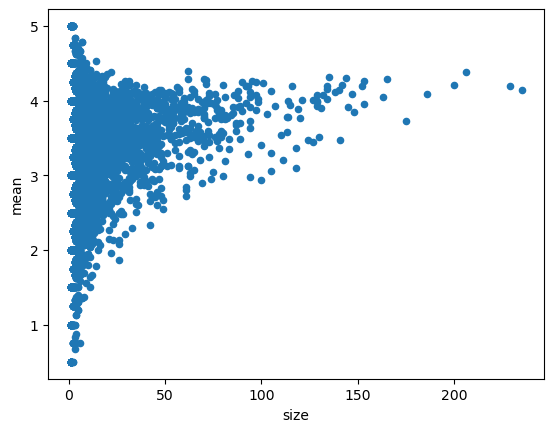

In [14]:
train_r.groupby(['item'])['rating'].agg(['size','mean']).plot.scatter('size','mean')

/Users/blake.tagget/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='size', ylabel='mean'>

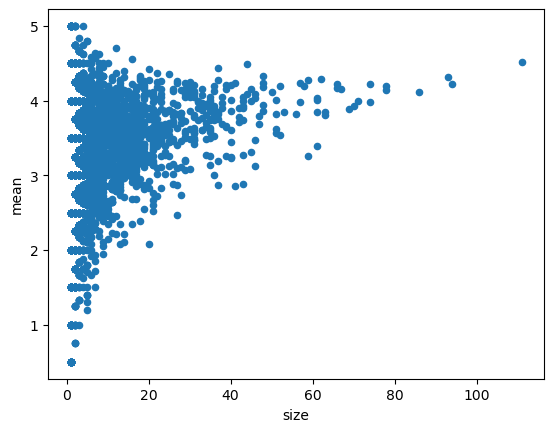

In [15]:
test_r.groupby(['item'])['rating'].agg(['size','mean']).plot.scatter('size','mean')

array([[<AxesSubplot: title={'center': 'startYear'}>]], dtype=object)

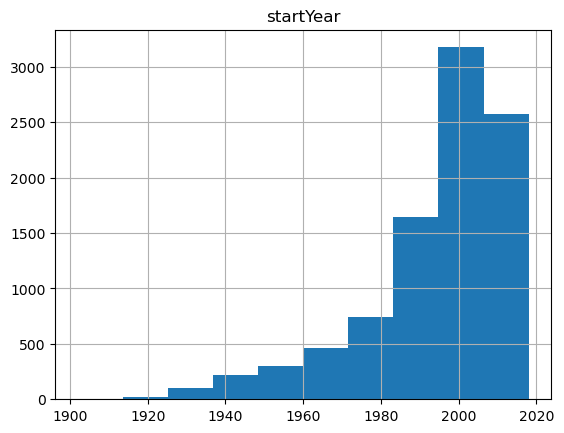

In [16]:
attr_nums.hist('startYear')

array([[<AxesSubplot: title={'center': 'averageRating'}>]], dtype=object)

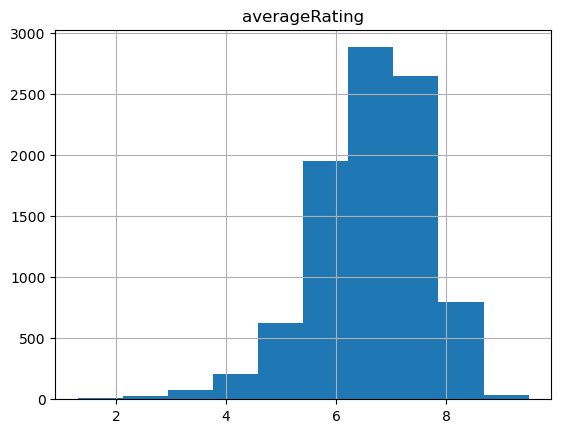

In [17]:
attr_nums.hist('averageRating')

array([[<AxesSubplot: title={'center': 'runtimeMinutes'}>]], dtype=object)

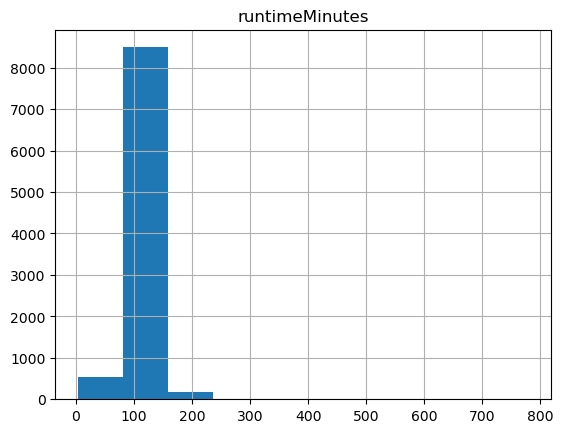

In [18]:
attr_nums.hist('runtimeMinutes')

### Discussion:

Our train and test datasets look to have a similar representation of movies. Also the population of movies looks to have a right skew'd rating scale. Generally speaking, movies a rated higher than a 5.

## Step 3 : Explore some similarity scores (an EDA activity)

In [19]:
# make a function to easily calc distance given a feature set and a distance function
def calc_distance(df,distance):
    dist_m = pd.DataFrame(squareform(pdist(df, distance)),index=df.index, columns= df.index)
    return dist_m

In [20]:
# calc a bunch of item-item similarity matrixes
attr_nums_dist = calc_distance(attr_nums, 'euclidean')
crew_euclid = calc_distance(imdb_has_people_pca, 'euclidean')
crew_cosine = calc_distance(imdb_has_people_pca, 'cosine')
tag_euclid = calc_distance(train_tags_pca, 'euclidean')
tag_cosine = calc_distance(train_tags_pca, 'cosine')

In [21]:
# find a different movie!
pd.DataFrame(attr_nums_dist.loc[187595].sort_values()).join(movies,how='left').join(imdb_people.groupby(['item'])['primaryName'].agg(list)).join(attr_nums).head()


,187595,title,genres,lk_tconst,primaryName,startYear,runtimeMinutes,averageRating,numVotes,total_ratings
item,,,,,,,,,,
187595,0.000000,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,tt3778644,"[Kathleen Kennedy, Alden Ehrenreich, Woody Har...",2018.0,135.0,6.9,353480,2439012.0
53322,9753.964866,Ocean's Thirteen (2007),Crime|Thriller,tt0496806,"[Jerry Weintraub, George Clooney, Brad Pitt, M...",2007.0,122.0,6.9,352081,2429358.9
99112,16442.717446,Jack Reacher (2012),Action|Crime|Thriller,tt0790724,"[Joe Kraemer, Tom Cruise, Rosamund Pike, Richa...",2012.0,130.0,7.0,346316,2424212.0
54272,19477.740471,"Simpsons Movie, The (2007)",Animation|Comedy,tt0462538,"[George Meyer, Dan Castellaneta, Julie Kavner,...",2007.0,87.0,7.3,334921,2444923.3
7293,19626.846549,50 First Dates (2004),Comedy|Romance,tt0343660,"[Teddy Castellucci, Adam Sandler, Drew Barrymo...",2004.0,99.0,6.8,361324,2457003.2


In [22]:
# find a different movie!
pd.DataFrame(crew_euclid.loc[187595].sort_values()).join(movies,how='left').join(imdb_people.groupby(['item'])['primaryName'].agg(list)).join(attr_nums).head()

,187595,title,genres,lk_tconst,primaryName,startYear,runtimeMinutes,averageRating,numVotes,total_ratings
item,,,,,,,,,,
187595,0.000000,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,tt3778644,"[Kathleen Kennedy, Alden Ehrenreich, Woody Har...",2018.0,135.0,6.9,353480,2439012.0
6821,0.322130,More American Graffiti (1979),Comedy,tt0079576,"[Caleb Deschanel, Candy Clark, Bo Hopkins, Ron...",1979.0,110.0,5.3,4707,24947.1
3363,0.347591,American Graffiti (1973),Comedy|Drama,tt0069704,"[Ron Eveslage, Richard Dreyfuss, Ron Howard, P...",1973.0,110.0,7.4,92140,681836.0
122886,0.485902,Star Wars: Episode VII - The Force Awakens (2015),Action|Adventure|Fantasy|Sci-Fi|IMAX,tt2488496,"[Kathleen Kennedy, Daisy Ridley, John Boyega, ...",2015.0,138.0,7.8,937743,7314395.4
69524,0.524817,Raiders of the Lost Ark: The Adaptation (1989),Action|Adventure|Thriller,tt0772251,"[Chris Strompolos, Angela Rodriguez, Michael B...",1989.0,100.0,8.0,777,6216.0


In [23]:
# find a different movie!
pd.DataFrame(crew_cosine.loc[187595].sort_values()).join(movies,how='left').join(imdb_people.groupby(['item'])['primaryName'].agg(list)).join(attr_nums).head()

,187595,title,genres,lk_tconst,primaryName,startYear,runtimeMinutes,averageRating,numVotes,total_ratings
item,,,,,,,,,,
187595,0.000000,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,tt3778644,"[Kathleen Kennedy, Alden Ehrenreich, Woody Har...",2018.0,135.0,6.9,353480,2439012.0
6821,0.079873,More American Graffiti (1979),Comedy,tt0079576,"[Caleb Deschanel, Candy Clark, Bo Hopkins, Ron...",1979.0,110.0,5.3,4707,24947.1
3363,0.098300,American Graffiti (1973),Comedy|Drama,tt0069704,"[Ron Eveslage, Richard Dreyfuss, Ron Howard, P...",1973.0,110.0,7.4,92140,681836.0
3259,0.144862,Far and Away (1992),Adventure|Drama|Romance,tt0104231,"[Daniel P. Hanley, Tom Cruise, Nicole Kidman, ...",1992.0,140.0,6.6,65216,430425.6
166528,0.178009,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi,tt3748528,"[George Lucas, Felicity Jones, Diego Luna, Ala...",2016.0,133.0,7.8,647294,5048893.2


In [24]:
# find a different movie!
pd.DataFrame(tag_euclid.loc[187595].sort_values()).join(movies,how='left').join(imdb_people.groupby(['item'])['primaryName'].agg(list)).join(attr_nums).head()


,187595,title,genres,lk_tconst,primaryName,startYear,runtimeMinutes,averageRating,numVotes,total_ratings
item,,,,,,,,,,
187595,0.000000,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,tt3778644,"[Kathleen Kennedy, Alden Ehrenreich, Woody Har...",2018.0,135.0,6.9,353480,2439012.0
61160,1.233546,Star Wars: The Clone Wars (2008),Action|Adventure|Animation|Sci-Fi,tt1185834,"[Catherine Winder, Matt Lanter, Nika Futterman...",2008.0,98.0,5.9,67710,399489.0
173291,1.351910,Valerian and the City of a Thousand Planets (2...,Action|Adventure|Sci-Fi,tt2239822,"[Thierry Arbogast, Dane DeHaan, Cara Delevingn...",2017.0,136.0,6.4,184917,1183468.8
65982,1.415722,Outlander (2008),Action|Adventure|Sci-Fi,tt0462465,"[Pierre Gill, Jim Caviezel, Sophia Myles, Ron ...",2008.0,115.0,6.2,76559,474665.8
70336,1.460098,G.I. Joe: The Rise of Cobra (2009),Action|Adventure|Sci-Fi|Thriller,tt1046173,"[Lorenzo di Bonaventura, Dennis Quaid, Channin...",2009.0,118.0,5.7,210531,1200026.7


In [25]:
# find a different movie!
pd.DataFrame(tag_cosine.loc[187595].sort_values()).join(movies,how='left').join(imdb_people.groupby(['item'])['primaryName'].agg(list)).join(attr_nums).head()


,187595,title,genres,lk_tconst,primaryName,startYear,runtimeMinutes,averageRating,numVotes,total_ratings
item,,,,,,,,,,
187595,0.000000,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,tt3778644,"[Kathleen Kennedy, Alden Ehrenreich, Woody Har...",2018.0,135.0,6.9,353480,2439012.0
101864,0.148015,Oblivion (2013),Action|Adventure|Sci-Fi|IMAX,tt1483013,"[Duncan Henderson, Tom Cruise, Morgan Freeman,...",2013.0,124.0,7.0,532284,3725988.0
65982,0.148862,Outlander (2008),Action|Adventure|Sci-Fi,tt0462465,"[Pierre Gill, Jim Caviezel, Sophia Myles, Ron ...",2008.0,115.0,6.2,76559,474665.8
61160,0.152467,Star Wars: The Clone Wars (2008),Action|Adventure|Animation|Sci-Fi,tt1185834,"[Catherine Winder, Matt Lanter, Nika Futterman...",2008.0,98.0,5.9,67710,399489.0
173291,0.157197,Valerian and the City of a Thousand Planets (2...,Action|Adventure|Sci-Fi,tt2239822,"[Thierry Arbogast, Dane DeHaan, Cara Delevingn...",2017.0,136.0,6.4,184917,1183468.8


In [26]:
# clear up some memory
del attr_nums_dist

del crew_euclid
del crew_cosine
del tag_euclid
del tag_cosine

### Discussion:

Look at that, for a sample Star Wars film, our feature attributes and PCA dimensionality reduction retain the correlation (business logic) we would need. We see that Solo is n-dimensionally close to other George Lucas films.

Sweet!


## Step 4 : Create the Model

In [41]:

# function city!!

def calc_sim(name,features,distance_calc):
    t0=time.perf_counter()
    sim = 1-squareform(pdist(features,distance_calc))
    scaler = MinMaxScaler()
    scaler.fit_transform(sim)
    
    t1=time.perf_counter()
    print(f'''{name} {distance_calc} similarity calculation time : ''',t1-t0)

    return sim

def predict(item_sim):
    t0=time.perf_counter()
    preds = np.ndarray(shape=len(test_r['user']))

    for row,user,item in zip(range(len(test_r['user'])),test_r['user'],test_r['item']):

        list_of_rating = train_ratings_mr[user_id.get(user)]
        list_of_movies = item_sim[item_id.get(item)]

        preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)

    preds[np.isnan(preds)]=3 #In case there is nan values in prediction, it will impute to 3.
    t1=time.perf_counter()
    print(f'''predict calculation time : ''',t1-t0)
    return preds


def error_rate(preds):    
    yt=np.array(test_r['rating'])
    error = np.sqrt(((yt-preds)**2).mean())
    print(error)
    return error

def convert_df_for_sim(df):
     return np.array(df.astype(pd.SparseDtype("int", 0)).sparse.to_coo().toarray())


def make_hybrid_sim(item_sim_map):
    sim_scores = np.ones(shape=(len(movies),len(movies)))
    for key,val in item_sim_map.items():
        sim_scores *= calc_sim(key,val[0], val[1])
    
    scaler = MinMaxScaler()
    scaler.fit_transform(sim_scores)
    
    return sim_scores
    
def run_model(item_sim_map):
    sim_scores = make_hybrid_sim(item_sim_map)
    
    pred = predict(sim_scores)
    
    return error_rate(pred)
    
    

### Discussion:

Not much to say here other than, I spent a lot of time to get here! **Making sure the algorithm makes efficient use of python data structures and objects is essential to having the notebook run in a "short" amout of time.** I'm talking 5 days! I'm not ashamed to say it. But now I know the things to address earlier in a like this project.

## Step 5. Find the best similarity scores for each feature set

In [28]:
# make some feature set and distance objects to calc best distance functions

cat_features = {
    'r':train_ratings_mr.T,
    'g':convert_df_for_sim(genres_df),
    'ab':convert_df_for_sim(attr_bool),
}
bool_distances = ['dice','hamming','yule','jaccard']

num_features = {
    'r':train_ratings_mr.T,
    'an':convert_df_for_sim(attr_nums),
    'p':convert_df_for_sim(imdb_has_people_pca),
    't':convert_df_for_sim(train_tags_pca)
}
num_distances = ['cosine','euclidean','braycurtis','canberra','chebyshev','correlation','seuclidean','sqeuclidean']


In [29]:
# let's determin the best singular model - loop through each feature set dict and distance function list
single_item_sim_models = {}

for name,sim in cat_features.items():
    print(name)
    single_item_sim_models[name]=single_item_sim_models.get(name,{})
    for dist in list(bool_distances):
        print(dist)
        try:
            single_item_sim_models[name][dist] = run_model({0:[sim,str(dist)]})
        except Exception as e:
            single_item_sim_models[name][dist]=f'''{str(e.__class__.__name__)}'''

for name,sim in num_features.items():
    print(name)
    single_item_sim_models[name]=single_item_sim_models.get(name,{})
    for dist in list(num_distances):
        print(dist)
        try:
            single_item_sim_models[name][dist] = run_model({0:[sim,str(dist)]})
        except Exception as e:
            single_item_sim_models[name][dist]=f'''{str(e.__class__.__name__)}'''


r
dice
0 dice similarity calculation time :  26.881667932


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.0188758329999956
0.9194304452306723
hamming
0 hamming similarity calculation time :  37.722947452
predict calculation time :  1.035485618999985
0.9433548766099663
yule
0 yule similarity calculation time :  55.298493792000016


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.0984423490000097
inf
jaccard
0 jaccard similarity calculation time :  21.486383966000005


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.0066150359999995
0.8895234326936754
g
dice
0 dice similarity calculation time :  3.1209050859999934


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  0.9968220910000127
0.9201070698305442
hamming
0 hamming similarity calculation time :  2.967335148000018
predict calculation time :  0.9790004210000234
0.9408999708906615
yule
0 yule similarity calculation time :  3.5028318709999837


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  0.9719688530000212
inf
jaccard
0 jaccard similarity calculation time :  2.7891021049999836


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  0.9868892549999941
0.918269500206824
ab
dice
0 dice similarity calculation time :  2.5060830390000035


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  0.9795507500000156
0.9436012097293524
hamming
0 hamming similarity calculation time :  2.408841582999969
predict calculation time :  1.0277298249999944
0.9438495800100112
yule
0 yule similarity calculation time :  3.131611721000013
predict calculation time :  0.9780458790000353
0.9443240774156871
jaccard
0 jaccard similarity calculation time :  2.433047472999988


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.0034831859999827
0.9435939487966806
r
cosine
0 cosine similarity calculation time :  36.15825218200001
predict calculation time :  1.0155252140000357
1.1583514403101687
euclidean
0 euclidean similarity calculation time :  57.35713376199999
predict calculation time :  0.9716064230000256
0.970070785875223
braycurtis
0 braycurtis similarity calculation time :  78.99431682399995


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.0098809990000177
0.9098680804610966
canberra
0 canberra similarity calculation time :  100.93257936500004
predict calculation time :  1.0471777860000202
0.9808031727398021
chebyshev
0 chebyshev similarity calculation time :  49.949583792
predict calculation time :  1.0318591530000276
0.9500530171553846
correlation
0 correlation similarity calculation time :  36.112237916000026
predict calculation time :  1.0014351119999674
1.1583514403101687
seuclidean
0 seuclidean similarity calculation time :  38.20091401600007
predict calculation time :  1.0275870299999497
0.9724839510062155
sqeuclidean
0 sqeuclidean similarity calculation time :  58.43713545899993
predict calculation time :  1.0678101390000165
1.0010753007847943
an
cosine
0 cosine similarity calculation time :  2.4185624299999517
predict calculation time :  1.0567866359999698
0.9437333418521536
euclidean
0 euclidean similarity calculation time :  2.3392387389999385
predict calculation time :  0.9895694

/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.0379542250000213
1.2374820612475974
braycurtis
0 braycurtis similarity calculation time :  3.2517083929999444


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)
/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.1010178249999854
inf
canberra
0 canberra similarity calculation time :  3.6803861900000356


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)
/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.0027945120000368
inf
chebyshev
0 chebyshev similarity calculation time :  2.673866111999928


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)
/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.0045623250000517
inf
correlation
0 correlation similarity calculation time :  2.9772357409999586
predict calculation time :  1.0304348390000087
1.1583514403101687
seuclidean
0 seuclidean similarity calculation time :  3.666031963000023
predict calculation time :  1.082058026000027
1.1583514403101687
sqeuclidean
0 sqeuclidean similarity calculation time :  2.6923262500000646


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)
/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.0416982810000945
inf
t
cosine
0 cosine similarity calculation time :  2.9377440199999683
predict calculation time :  1.0114471670000285
1.1583514403101687
euclidean
0 euclidean similarity calculation time :  2.6800394090000736
predict calculation time :  1.2864943429999585
1203.213881829441
braycurtis
canberra
0 canberra similarity calculation time :  3.8192302300000165


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  0.9841306579999127
inf
chebyshev
0 chebyshev similarity calculation time :  2.56946270800006


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)
/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.0300247760000047
inf
correlation
0 correlation similarity calculation time :  3.1245951869999544
predict calculation time :  1.068777076999936
1.1583514403101687
seuclidean
0 seuclidean similarity calculation time :  3.474001199999975
predict calculation time :  0.9981902749999563
1.1472158876468186
sqeuclidean
0 sqeuclidean similarity calculation time :  2.7165361300000086


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  0.993820626999991
inf


In [30]:
# let's take the best of each sitance results and try out the different combinations
single_results = pd.DataFrame.from_dict(single_item_sim_models)
single_results

,r,g,ab,an,p,t
dice,0.919430,0.920107,0.943601,NaN,NaN,NaN
hamming,0.943355,0.940900,0.943850,NaN,NaN,NaN
yule,inf,inf,0.944324,NaN,NaN,NaN
jaccard,0.889523,0.918270,0.943594,NaN,NaN,NaN
cosine,1.158351,NaN,NaN,0.943733,1.158351,1.158351
euclidean,0.970071,NaN,NaN,1.037114,1.237482,1203.213882
braycurtis,0.909868,NaN,NaN,0.910679,inf,ValueError
canberra,0.980803,NaN,NaN,417.955247,inf,inf
chebyshev,0.950053,NaN,NaN,1.037366,inf,inf
correlation,1.158351,NaN,NaN,0.943725,1.158351,1.158351


### Discussion:

The above table shows us that not all distance metrics are applicable and that the jaccard similarity for the ratings matrix is our best single model. Let's see if any combinations can make the score better!

Since the tags don't seem to help, we will exclude them. We could however change our PCA, or add all tags, in order to improve this. But we will move on.


## Step 6 : Find the best combined model set - forward selection approach

In [31]:
best_features = {
    'r':[train_ratings_mr.T,single_results['r'].idxmin(axis=0)],
    'an':[convert_df_for_sim(attr_nums),single_results['an'].idxmin(axis=0)],
}

run_model(best_features)

r jaccard similarity calculation time :  21.59389110799998
an braycurtis similarity calculation time :  2.4597866949999343


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.0541072319999785
0.8804253779067628


0.8804253779067628

In [32]:
best_features = {
    'r':[train_ratings_mr.T,single_results['r'].idxmin(axis=0)],
    'ab':[convert_df_for_sim(attr_nums),single_results['ab'].idxmin(axis=0)],
}

run_model(best_features)

r jaccard similarity calculation time :  22.033449020000035
ab jaccard similarity calculation time :  2.690447488000018


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.2892927209999243
0.8739275697445853


0.8739275697445853

In [33]:
best_features = {
    'r':[train_ratings_mr.T,single_results['r'].idxmin(axis=0)],
    'g':[convert_df_for_sim(genres_df),single_results['g'].idxmin(axis=0)],
}

run_model(best_features)

r jaccard similarity calculation time :  21.693341049999958
g jaccard similarity calculation time :  2.892726186999994


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.0380796509999755
0.8794473421170818


0.8794473421170818

In [34]:
best_features = {
    'r':[train_ratings_mr.T,single_results['r'].idxmin(axis=0)],
    'g':[convert_df_for_sim(genres_df),single_results['g'].idxmin(axis=0)],
    'an':[convert_df_for_sim(attr_nums),single_results['an'].idxmin(axis=0)],
}

run_model(best_features)

r jaccard similarity calculation time :  21.59774762799998
g jaccard similarity calculation time :  2.8789346830000113
an braycurtis similarity calculation time :  2.3881458800000246


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  0.9860217629999397
0.8741658261562708


0.8741658261562708

In [35]:
best_features = {
    'r':[train_ratings_mr.T,single_results['r'].idxmin(axis=0)],
    'g':[convert_df_for_sim(genres_df),single_results['g'].idxmin(axis=0)],
    'ab':[convert_df_for_sim(attr_bool),single_results['ab'].idxmin(axis=0)],
    'an':[convert_df_for_sim(attr_nums),single_results['an'].idxmin(axis=0)],
}

run_model(best_features)

r jaccard similarity calculation time :  21.344860605999997
g jaccard similarity calculation time :  2.764070265999976
ab jaccard similarity calculation time :  2.5158958020000455
an braycurtis similarity calculation time :  2.480855272000099


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/2645572126.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.120137366999984
0.874579311205187


0.874579311205187

In [36]:
best_features = {
    'r':[train_ratings_mr.T,single_results['r'].idxmin(axis=0)],
    'g':[convert_df_for_sim(genres_df),single_results['g'].idxmin(axis=0)],
    'ab':[convert_df_for_sim(attr_bool),single_results['ab'].idxmin(axis=0)],
    'an':[convert_df_for_sim(attr_nums),single_results['an'].idxmin(axis=0)],
    'p':[convert_df_for_sim(imdb_has_people_pca),single_results['p'].idxmin(axis=0)]
    
}

run_model(best_features)

r jaccard similarity calculation time :  21.651486787999943
g jaccard similarity calculation time :  2.9755096640001284
ab jaccard similarity calculation time :  2.4976235980000183
an braycurtis similarity calculation time :  2.3998979919999783
p cosine similarity calculation time :  3.101136760000145
predict calculation time :  0.9874382819998573
1.1583514403101687


1.1583514403101687

### Discussion:

That's a lot of printouts! I could have added automation here, but i'm so burnt out. I came, I learned, I concured what I set out to do.

**I used a Forward Selection Technique** to manually check which combinations of the best single distance metrics give the best over all results. Here we can see that the best model involves :
- Training ratings matrix (train_ratings_mr)
- IMDb boolean attributes (attr_nums)

This was an interesting finding. It seems that format matters ...  

I was really hoping the IMDb Crew feature set would make the list becasue, to me, it's one of the more important recommendation relevant pieces. 


## Step 7 : Make a Recommendation

In [54]:
best_score = {
    'r':[train_ratings_mr.T,'jaccard'],
    'ab':[convert_df_for_sim(attr_nums),'jaccard'],
}
score_item_sim = make_hybrid_sim(best_score)
score_predicted_ratings = predict(score_item_sim)

r jaccard similarity calculation time :  21.63689882799963
ab jaccard similarity calculation time :  2.633305307000228


/var/folders/7f/vp4rxn4s03db1tvmq1976xx80000gp/T/ipykernel_25732/1911664478.py:23: RuntimeWarning: invalid value encountered in double_scalars
  preds[row] = np.dot(list_of_rating,list_of_movies)/np.dot(list_of_movies,list_of_rating>0)


predict calculation time :  1.0276797219999025


In [60]:
best_logic = {
    'r':[train_ratings_mr.T,'jaccard'],
    'g':[convert_df_for_sim(genres_df),'jaccard'],
    'ab':[convert_df_for_sim(attr_bool),'jaccard'],
    'an':[convert_df_for_sim(attr_nums),'braycurtis'],
    'p':[convert_df_for_sim(imdb_has_people_pca),'seuclidean'],
    't':[convert_df_for_sim(imdb_has_people_pca),'seuclidean'],
}
logic_item_sim = make_hybrid_sim(best_logic)
logic_predicted_ratings = predict(logic_item_sim)

r jaccard similarity calculation time :  22.978474770000048
g jaccard similarity calculation time :  3.186868673999925
ab jaccard similarity calculation time :  2.6598049809999793
an braycurtis similarity calculation time :  2.482857048999904
p seuclidean similarity calculation time :  3.752849141000297
t seuclidean similarity calculation time :  3.895839892999902
predict calculation time :  1.2037724220003838


In [61]:
def recommend(sample_user,top,predicted_ratings):
    movies_rated = train_r.sort_values(by='rating',ascending=False).join(movies,on='item')
    movies_recommended = test_r.reset_index(drop=True).join(pd.Series(predicted_ratings,name='pred_rating'))
    movies_recommended = movies_recommended.sort_values(by='pred_rating',ascending=False).join(movies,on='item')
    print(f"""Top {top} Rated Movies for user {sample_user}""")
    print(movies_rated[movies_rated['user']==sample_user][['title']].head(top))
    print('')
    print(f"""Top {top} Recommendations for user {sample_user}""")
    print(movies_recommended[movies_recommended['user']==sample_user][['title']].head(top))
    

In [64]:

recommend(453,10,score_predicted_ratings)

Top 10 Rated Movies for user 453
                                           title
70875  Naked Gun 33 1/3: The Final Insult (1994)
70953                   Big Lebowski, The (1998)
70947                    Truman Show, The (1998)
71138                   Beautiful Mind, A (2001)
70912     Monty Python and the Holy Grail (1975)
70981                       Pleasantville (1998)
70966                          Armageddon (1998)
70866                           Quiz Show (1994)
70926     Beavis and Butt-Head Do America (1996)
71025                          Fight Club (1999)

Top 10 Recommendations for user 453
                                   title
23694   Shawshank Redemption, The (1994)
15211                     Aladdin (1992)
7516                 Pulp Fiction (1994)
29626                   Toy Story (1995)
17027               Groundhog Day (1993)
7718            Good Will Hunting (1997)
29702            Sixth Sense, The (1999)
11761                  Casablanca (1942)
23819                 

In [65]:
recommend(453,10,logic_predicted_ratings)

Top 10 Rated Movies for user 453
                                           title
70875  Naked Gun 33 1/3: The Final Insult (1994)
70953                   Big Lebowski, The (1998)
70947                    Truman Show, The (1998)
71138                   Beautiful Mind, A (2001)
70912     Monty Python and the Holy Grail (1975)
70981                       Pleasantville (1998)
70966                          Armageddon (1998)
70866                           Quiz Show (1994)
70926     Beavis and Butt-Head Do America (1996)
71025                          Fight Club (1999)

Top 10 Recommendations for user 453
                                                   title
20449                   Men in Black (a.k.a. MIB) (1997)
19179                There's Something About Mary (1998)
19196                               Waterboy, The (1998)
18938                So I Married an Axe Murderer (1993)
19466                                Billy Elliot (2000)
19502                                          Go

### Discussion:

Look at that, two recommendations: 
1. The one using the "best model" (the one with the lowest error) produced pretty bland and objectively wrong recommendations. 
2. the one with inclusivity of all the feature sets produced a list of recommendations that look a lot better when you think about the actual movies in each top 5, in my opinion. 

## Step 8 : Discussion / Overall Conclusion

Overall, we have here a model which allows us to pick the features we want to use to recommend the next movie to watch. At the end of the day it's pretty straight forward: When a user has already provided some ratings (no cold start), we can find other similarly rated movies and recommend them. The movie similarity is where the hybrid name comes in as we join multiple similarity scores.

### Learning and takeaways :

Data is hard when it's hard! I am used to working in pandas and spreadsheets. Changing my mental perception to COO format was a learning curve that I discovered late in the game.


### What didn’t work :

Using other users ratings to create a user-user similarity matrix to incorporate here. The idea was realted to the probablitity that a movie is a relevant recommendation becuase others like me liked them. I'm still confident this can work, I just ran out of steam.


### Ways to improve : 

I could expore and utilize skLearns pipeline libraries to see if that automation I did could be outsourced. I spent so much time on the algo efficiency that there was much time left to figure the best pipeline.

I could also turn the various feature sets themselves. at the moment when we put them together we treat them all with equal weight. All features inside a set and given the same weight and all sets are given the same weight to eachother.

